# Depth-vs-Performance Study
This notebook runs Nelder-Mead optimizations for `p>1` on both MaxCut and 2-SAT instances, mirroring the trends highlighted in Willsch et al.

In [7]:
from pathlib import Path
import sys

REPO_ROOT = Path.cwd().resolve().parent
SRC_ROOT = REPO_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.insert(0, str(SRC_ROOT))

In [17]:
import numpy as np
import pandas as pd
from problems.maxcut import generate_maxcut_instance
from problems.sat import generate_2sat_instance
from problems.knapsack import generate_knapsack_instance
from qaoa.circuits import CostHamiltonian, maxcut_hamiltonian
from qaoa.experiments import run_depth_experiment, run_parameter_grid
from qaoa.knapsack_analysis import penalty_parameter_sweep
from qaoa.statistics import repeated_depth_experiments
from visualization.landscapes import plot_optimization_progress
from visualization.dashboard import create_results_dashboard
from classical.knapsack import greedy_knapsack, dynamic_programming_knapsack, comparison_table

In [19]:
import importlib
import visualization.dashboard as dashboard_module
importlib.reload(dashboard_module)
create_results_dashboard = dashboard_module.create_results_dashboard

In [9]:
maxcut_instance = generate_maxcut_instance(6, 0.5, weighted=False, seed=11)
maxcut_h = maxcut_hamiltonian(maxcut_instance.weights, maxcut_instance.n_nodes)
sat_instance = generate_2sat_instance(6, 10, ensure_satisfiable=True, seed=21)
sat_h = CostHamiltonian(sat_instance.h, sat_instance.J, sat_instance.n_variables)
print(f"MaxCut ground energy: {maxcut_instance.ground_state_energy:.3f}")
print(f"2-SAT ground energy: {sat_instance.ground_energy:.3f}")

MaxCut ground energy: -7.000
2-SAT ground energy: -1.500


In [10]:
p_values = [1, 2, 3]
records = []
histories = {}
for label, hamiltonian, ground_states, e_min, e_max in [
    ("MaxCut", maxcut_h, maxcut_instance.ground_state_bitstrings, maxcut_instance.ground_state_energy, maxcut_instance.energy_ceiling),
    ("2-SAT", sat_h, sat_instance.ground_states, sat_instance.ground_energy, 0.0),
]:
    for p in p_values:
        result = run_depth_experiment(
            hamiltonian=hamiltonian,
            ground_states=ground_states,
            energy_min=e_min,
            energy_max=e_max,
            p=p,
            n_restarts=5,
            shots=256,
        )
        best_run = min(result.optimization_runs, key=lambda r: r.value)
        histories[(label, p)] = best_run.history
        records.append(
            {
                "Problem": label,
                "p": p,
                "Mean energy": result.analysis.energy_mean,
                "Success": result.analysis.success_probability,
                "Approximation": result.analysis.approximation_ratio,
            }
        )
results_df = pd.DataFrame(records)
results_df

,Problem,p,Mean energy,Success,Approximation
0,MaxCut,1,-2.492188,0.192871,0.718262
1,MaxCut,2,-2.867188,0.241211,0.741699
2,MaxCut,3,-2.888672,0.327148,0.743042
3,2-SAT,1,-1.366211,0.044434,0.910807
4,2-SAT,2,-1.439453,0.052246,0.959635
5,2-SAT,3,-1.059082,0.065918,0.706055


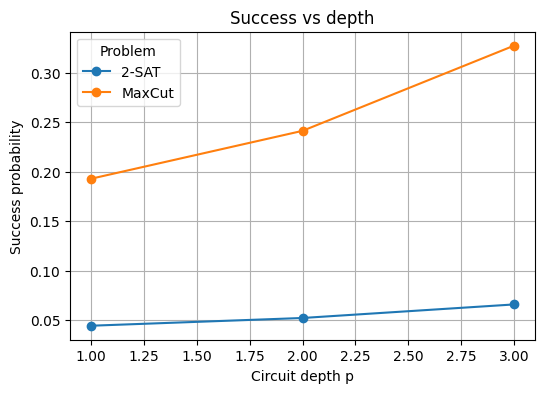

In [11]:
pivot = results_df.pivot(index="p", columns="Problem", values="Success")
ax = pivot.plot(marker="o", figsize=(6, 4))
ax.set_ylabel("Success probability")
ax.set_xlabel("Circuit depth p")
ax.set_title("Success vs depth")
ax.grid(True)

MaxCut optimization history (p=3)


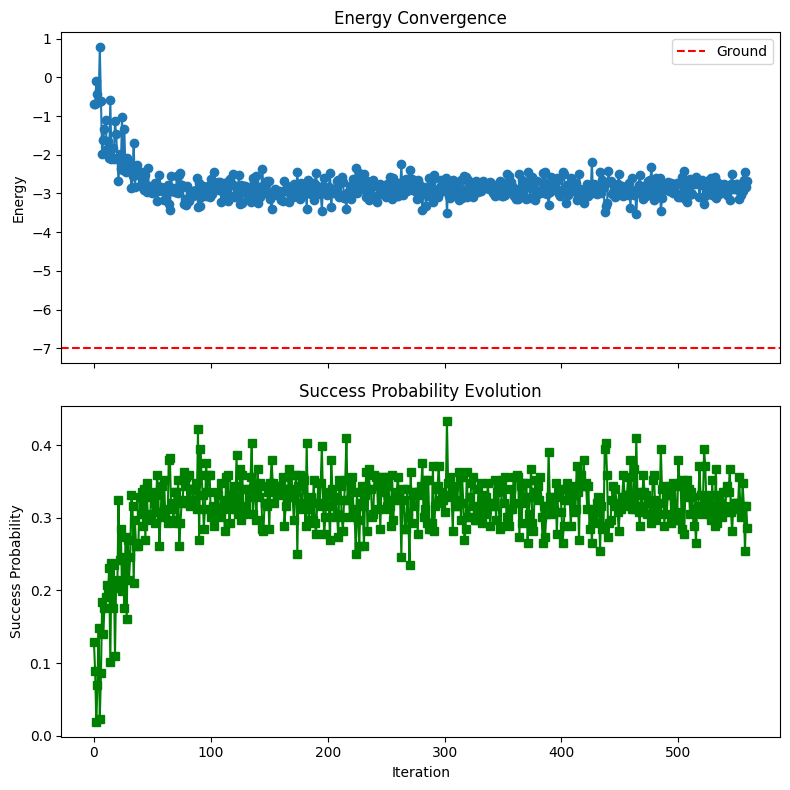

2-SAT optimization history (p=3)


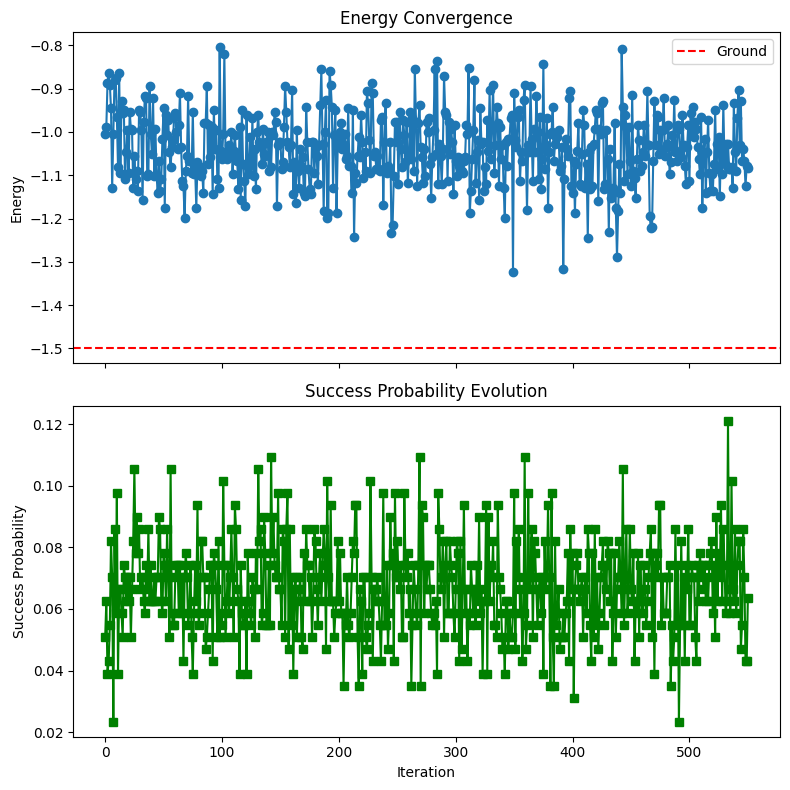

In [12]:
for (label, p), history in histories.items():
    if p == max(p_values):
        print(f"{label} optimization history (p={p})")
        plot_optimization_progress(
            history,
            ground_energy=maxcut_instance.ground_state_energy if label == "MaxCut" else sat_instance.ground_energy,
        )

In [13]:
maxcut_stats = repeated_depth_experiments(
    hamiltonian=maxcut_h,
    ground_states=maxcut_instance.ground_state_bitstrings,
    energy_min=maxcut_instance.ground_state_energy,
    energy_max=maxcut_instance.energy_ceiling,
    p=2,
    repeats=5,
    n_restarts=3,
    shots=256,
 )
sat_stats = repeated_depth_experiments(
    hamiltonian=sat_h,
    ground_states=sat_instance.ground_states,
    energy_min=sat_instance.ground_energy,
    energy_max=0.0,
    p=2,
    repeats=5,
    n_restarts=3,
    shots=256,
 )
summary_df = pd.DataFrame(
    [
        {
            "Problem": "MaxCut",
            "Mean Energy": maxcut_stats.mean_energy,
            "Std Energy": maxcut_stats.std_energy,
            "Mean Success": maxcut_stats.mean_success,
            "Std Success": maxcut_stats.std_success,
        },
        {
            "Problem": "2-SAT",
            "Mean Energy": sat_stats.mean_energy,
            "Std Energy": sat_stats.std_energy,
            "Mean Success": sat_stats.mean_success,
            "Std Success": sat_stats.std_success,
        },
    ]
)
summary_df

,Problem,Mean Energy,Std Energy,Mean Success,Std Success
0,MaxCut,-3.085547,0.515286,0.289844,0.091445
1,2-SAT,-1.202148,0.586027,0.030957,0.020051


In [14]:
gamma_dense = np.linspace(0, 2 * np.pi, 41)
beta_dense = np.linspace(0, np.pi, 41)
maxcut_grid_result = run_parameter_grid(
    hamiltonian=maxcut_h,
    ground_states=maxcut_instance.ground_state_bitstrings,
    energy_min=maxcut_instance.ground_state_energy,
    energy_max=maxcut_instance.energy_ceiling,
    gamma_values=gamma_dense,
    beta_values=beta_dense,
    shots=256,
 )
sat_grid_result = run_parameter_grid(
    hamiltonian=sat_h,
    ground_states=sat_instance.ground_states,
    energy_min=sat_instance.ground_energy,
    energy_max=0.0,
    gamma_values=gamma_dense,
    beta_values=beta_dense,
    shots=256,
 )
knapsack_instance = generate_knapsack_instance(n_items=6, capacity_ratio=0.5, seed=5)
lambda_sweep = [5, 10, 20, 40, 80]
penalty_summary = penalty_parameter_sweep(
    instance=knapsack_instance,
    lambda_values=lambda_sweep,
    p=1,
    shots=256,
    n_restarts=2,
 )
penalty_df = pd.DataFrame.from_dict(penalty_summary, orient="index").sort_index()
greedy_solution = greedy_knapsack(knapsack_instance.values, knapsack_instance.weights, knapsack_instance.capacity)
dp_solution = dynamic_programming_knapsack(knapsack_instance.values, knapsack_instance.weights, knapsack_instance.capacity)
lam_choice = 20.0
qaoa_rows = [
    {
        "Method": f"QAOA (p=1, λ={lam_choice:.0f})",
        "Value": penalty_summary[lam_choice]["best_value"],
        "Time (ms)": np.nan,
        "Success Rate": penalty_summary[lam_choice]["feasibility_rate"],
        "Approx Ratio": penalty_summary[lam_choice]["approx_ratio"],
    }
 ]
comparison_df = comparison_table(
    optimal_value=knapsack_instance.optimal_value,
    optimal_method="Brute Force",
    baseline_solutions=[greedy_solution, dp_solution],
    qaoa_rows=qaoa_rows,
 )
penalty_df

,feasibility_rate,approx_ratio,best_value,avg_violation
5.0,0.505371,1.0,59.0,3.310345
10.0,0.469727,1.0,59.0,3.307692
20.0,0.531738,1.0,59.0,3.310345
40.0,0.600098,1.0,59.0,3.392857
80.0,0.562500,1.0,59.0,3.310345


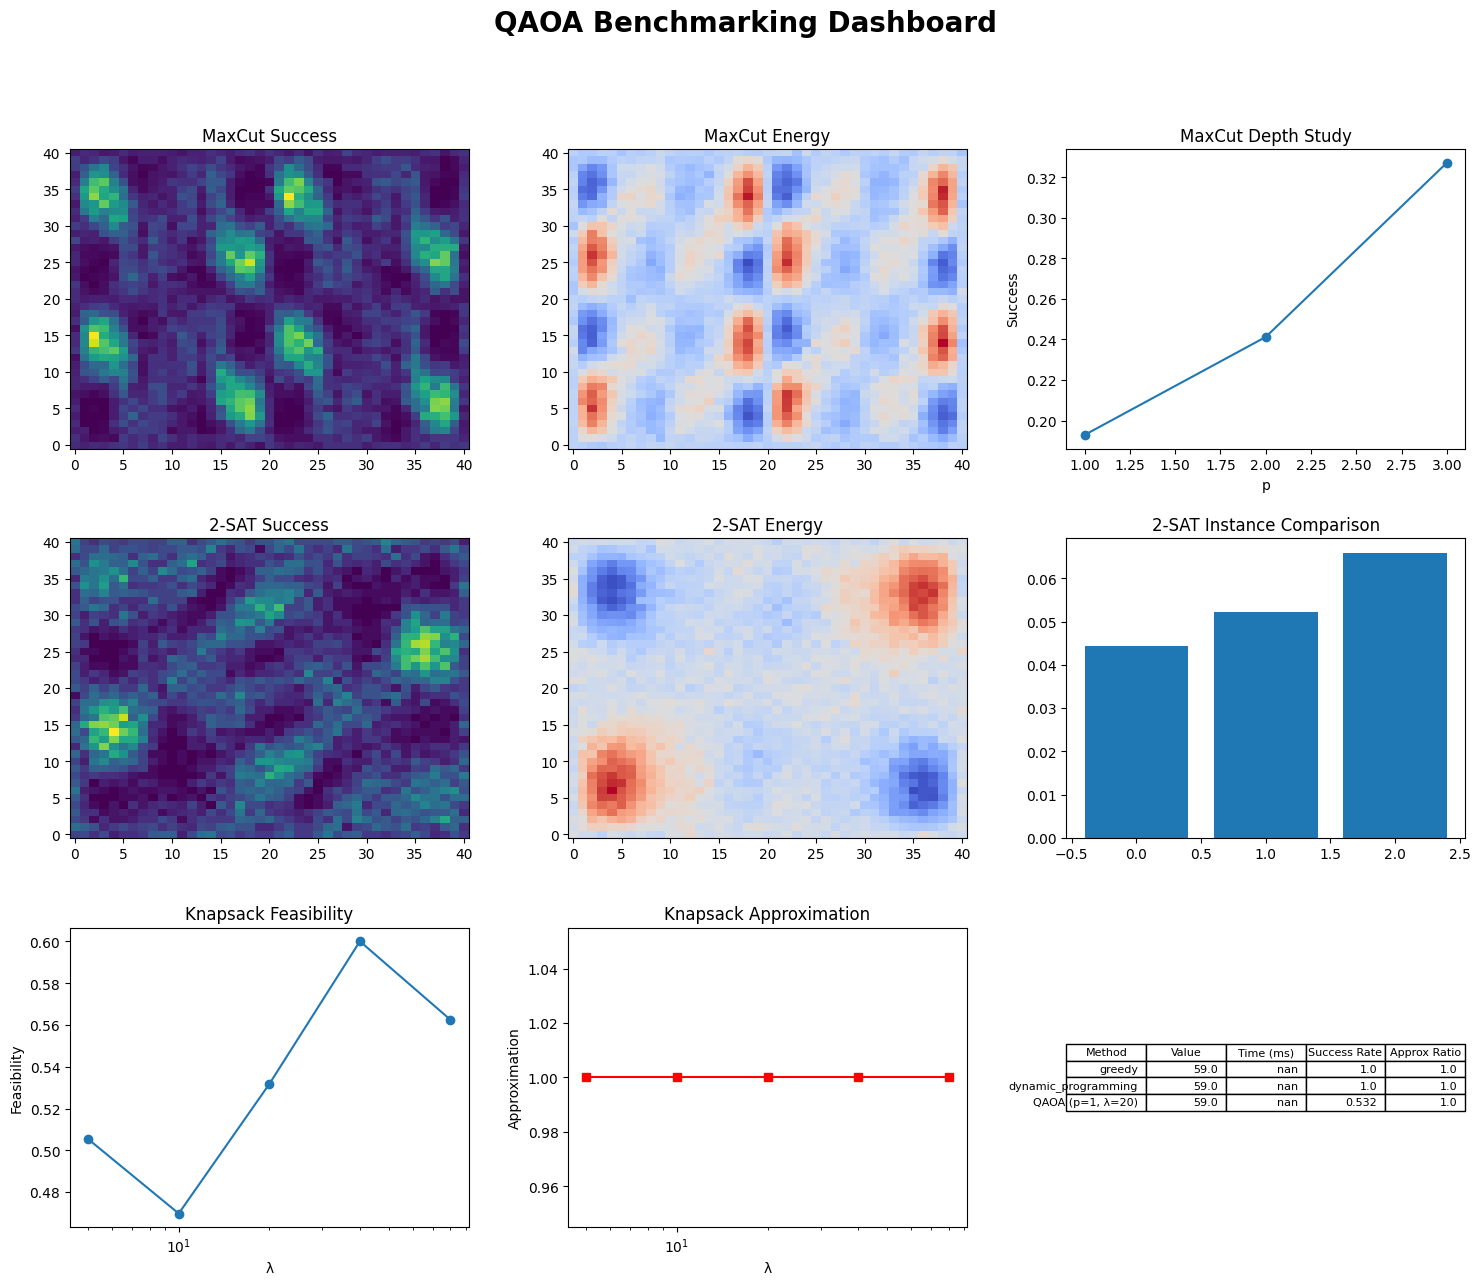

Dashboard saved to /Users/g-shack/Python Project/qaoa-repro/figures/qaoa_dashboard.png


In [20]:
figures_dir = (REPO_ROOT / "figures")
figures_dir.mkdir(exist_ok=True)
dashboard_path = figures_dir / "qaoa_dashboard.png"
maxcut_mask = results_df["Problem"] == "MaxCut"
sat_mask = results_df["Problem"] == "2-SAT"
create_results_dashboard(
    maxcut_panels={
        "success": maxcut_grid_result.grid.success_grid,
        "energy": maxcut_grid_result.grid.energy_grid,
        "p_values": results_df[maxcut_mask]["p"].to_numpy(),
        "success_vs_p": results_df[maxcut_mask]["Success"].to_numpy(),
    },
    sat_panels={
        "success": sat_grid_result.grid.success_grid,
        "energy": sat_grid_result.grid.energy_grid,
        "instances": [f"p={p}" for p in results_df[sat_mask]["p"]],
        "instance_success": results_df[sat_mask]["Success"].tolist(),
    },
    knapsack_metrics={
        "lambda": penalty_df.index.tolist(),
        "feasibility": penalty_df["feasibility_rate"].tolist(),
        "approximation": penalty_df["approx_ratio"].tolist(),
    },
    comparison_table=comparison_df,
    save_path=str(dashboard_path),
)
print(f"Dashboard saved to {dashboard_path}")

## Takeaways
- Success probabilities climb with depth but remain problem dependent (2-SAT lags MaxCut).
- Optimal regions remain narrow, requiring multiple restarts.
- Convergence traces highlight plateaus consistent with the paper's findings.